# Exploratory Analysis of Messi's Career

This notebook aims to take a very broad look at the numbers behind Messi's career and how they have changed with time. The data is part of StatBomb's [free data](https://statsbomb.com/academy/).

Statistics explored include:\
\
**Playing Positions**
- In what positions have Messi started most matches?

**Shots**
- Shot quantity separated by body part used.
- Conversion rate separated by body part and compared to Barcelona average.
- Goal to Expected goal (xG) difference separated by body part and compared to Barcelona average.
- Fraction of Barcelona goals and xG accounted for by Messi.

**Passing**
- Quantity (focusing on open play): Total, Final Third, Penalty Area, Through Balls, Crosses, Switches.
- Comparing Assists and Expected Assists (xA) (using the xG of the assisted shot).
- Progressive passes; defined as a pass that moves the ball at least 30m towards the goal, if from own half, or 10m towards the goal if from opposition half. These are not defined in the StatsBomb data but are calculated in the ``get_pass`` function from ``importing_sb.py``.

**Carries and Dribbles**
- Progressive carries. These are not defined the StatsBomb data so must be self defined. I define a Progressive Carry as one which moves the ball at least 5m towards the goal. These are found using the ``get_carry_prog`` function from ``importing_sb.py``. This function also offers the option for finding the action following the carry and whether it was successful with the option ``find_success = True``.
- Progressive carry outcomes: Average distance, xG and xA, Success rate, Ending Actions Proportions, Carries into box.
- Comparing the fraction of Final Third Passes which follow a carry to the fraction of xA that comes from these passes. This allows one to see whether Messi creates better goal scoring opportunities with passes following carries.

In [1]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from cycler import cycler
from highlight_text.htext import htext, fig_htext
import importlib

import importing_sb as imsb
import draw_pitch as dp

importlib.reload(imsb) # Reloads importing_sb.py rather than having to restart the kernel to get changes to importing_sb.py
importlib.reload(dp)

plt.style.use('football')

%matplotlib inline

In [2]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['pdf.fonttype'] = 42 # Allows chosen font to work when saving images to pdf

Get the La Liga *season id's* and import the match data.

In [3]:
data_dir = 'data/open-data/data/'

comp_data = imsb.open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(imsb.open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

Find the *match id's* using the match data.

In [4]:
years = list(range(2018,2003,-1))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06','04/05']
match_id = {}
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_id[str(years[i])] = df['match_id'].values

Get the *lineup* and *event* data using these *match id's*.

In [5]:
event_data = {}
lineup_data = {}
for year in years:
    event_data[str(year)] = []
    lineup_data[str(year)] = []
    for match in match_id[str(year)]:
        event_data[str(year)].append(imsb.open_data(data_dir + 'events/{}.json'.format(str(match))))
        lineup_data[str(year)].append(imsb.open_data(data_dir + 'lineups/{}.json'.format(str(match))))

Get player nicknames for cleaner visualisations.

In [6]:
nicknames = {}
for year in years:
    for match in lineup_data[str(year)]:
        for team in match:
            if team['team_name'] == 'Barcelona':
                for players in team['lineup']:
                    if players['player_nickname'] == None:
                        nicknames[str(players['player_name'])] = str(players['player_name'])
                    else:
                        nicknames[str(players['player_name'])] = str(players['player_nickname'])

The data from the 18/19 season will be commonly be used for examples so is given its own variable here.

In [7]:
event_data_18 = [i for match in event_data['2018'] for i in match]

In [8]:
messi = 'Lionel Andrés Messi Cuccittini'

Calculating the number of 90s played per season for Messi.

In [9]:
# Calculate amount of 90s played per season
m_90_played = []
for year in years:
    tot = 0
    for i in range(len(event_data[str(year)])):
        tot += imsb.get_player_info(event_data[str(year)][i],messi).sec_played
        
    m_90_played.append((tot / 60) / 90)

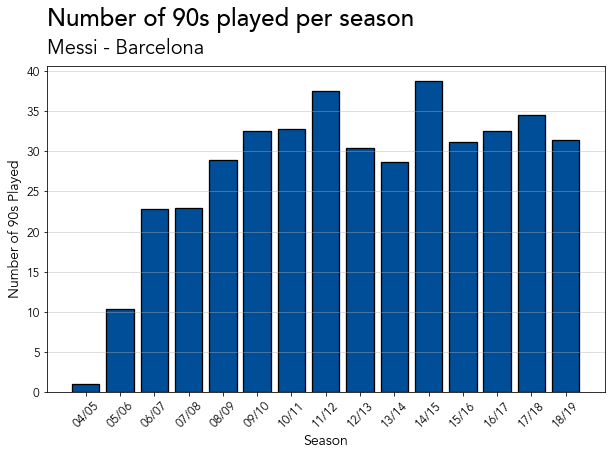

In [10]:
ind = list(reversed(np.arange(len(years))))

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(ind, m_90_played)
ax.set(xticks=ind,xlabel='Season',ylabel='Number of 90s Played')
ax.set_xticklabels(seasons, rotation=45)
ax.grid(axis='y',alpha=0.5)

ax.text(0,1.1,"Number of 90s played per season",transform=ax.transAxes,va='bottom',fontsize=24,
       fontweight='medium')
ax.text(0,1.02,"Messi - Barcelona",transform=ax.transAxes,va='bottom',fontsize=20)

plt.show()

## Playing Position

In [11]:
# Excluding 04/05
years_pos = years[:-1]
seasons_pos = seasons[:-1]
m_info = {}
m_info_starts = {}
for year in years_pos:
    m_info[str(year)] = pd.DataFrame([imsb.get_player_info(event_data[str(year)][i],messi) for i in range(len(event_data[str(year)]))]).reset_index(drop=True)
    m_info_starts[str(year)] = m_info[str(year)][m_info[str(year)]['position'].notna()]

In [12]:
# Creating DataFrame where rows is the season and columns count amount of games started in that position
pos_played = pd.DataFrame()
for i in pd.concat(m_info_starts).position.unique():
    pos_list = []
    for year in years_pos:
        if str(i) in m_info_starts[str(year)]['position'].value_counts().index:
            pos_list.append(m_info_starts[str(year)]['position'].value_counts().loc[str(i)])
        else:
            pos_list.append(0)
    pos_played[str(i)] = pos_list

# Find number of games started
gp = []
for i in range(len(pos_played)):
    gp.append(pos_played.iloc[i].sum())

In [13]:
#Sorting such that columns are ordered from most common position to least
pos_played = pos_played[pos_played.sum().sort_values(ascending=False).index]

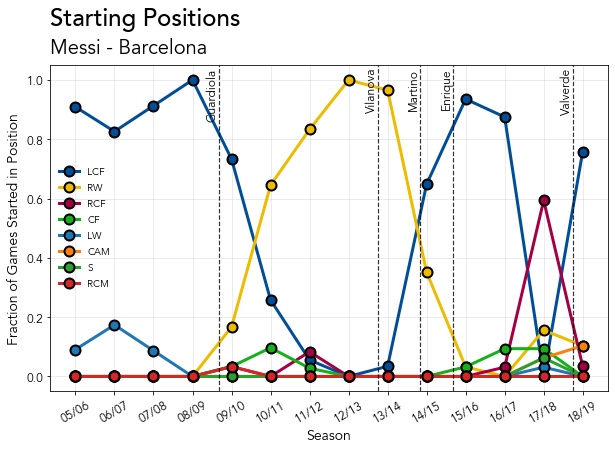

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

ind = np.flip((np.arange(len(years_pos))))
labels = ['LCF','RW','RCF','CF','LW','CAM','S','RCM']
man_dates = [0,3+(8/12),7+(9/12),8+(10/12),9+(8/12),12+(9/12)]
man_names = ['Rijkaard','Guardiola','Vilanova','Martino','Enrique','Valverde']

for i in range(len(pos_played.columns)):
    ax.plot(ind, pos_played[str(pos_played.columns[i])].values / np.array(gp),'-o',mec='k',label=labels[i])
    
for i in range(len(man_dates)-1):
    ax.axvline(man_dates[i+1],0,1,c='k',ls='--',lw=1.2,alpha=0.8)
    ax.text(man_dates[i+1],1.04,man_names[i+1],fontsize=12,ha='right',va='top',rotation=90)
    
ax.set(xticks=ind,xticklabels=seasons_pos,xlabel='Season',ylabel='Fraction of Games Started in Position')
ax.set_xticklabels(seasons_pos,rotation=30)
ax.grid(alpha=0.3)
ax.legend(frameon=False)

ax.text(0.0,1.1,'Starting Positions',transform=ax.transAxes,va='bottom',fontsize=24,fontweight='medium')
ax.text(0,1.02,"Messi - Barcelona",transform=ax.transAxes,va='bottom',fontsize=20)

plt.show()

## Shots

In [15]:
shots = {}
for year in years:
    shots[str(year)] = [imsb.get_shots(match) for match in event_data[str(year)]]

In [16]:
shots_seas = {}
for year in shots:
    shots_seas[str(year)] = pd.concat(shots[str(year)])
    shots_seas[str(year)].reset_index(inplace=True)

In [17]:
m_shots_seas = {}
barca_shots_seas = {}
for year in years:
    m_shots_seas[str(year)] = shots_seas[str(year)][shots_seas[str(year)]['player'] == messi]
    barca_shots_seas[str(year)] = shots_seas[str(year)][shots_seas[str(year)]['team'] == 'Barcelona']

In [18]:
m_seas_h = {}
m_seas_lf = {}
m_seas_rf = {}
for year in years:
    m_seas_h[str(year)] = m_shots_seas[str(year)][(m_shots_seas[str(year)]['body_part'] == 'Head')]
    m_seas_lf[str(year)] = m_shots_seas[str(year)][(m_shots_seas[str(year)]['body_part'] == 'Left Foot')]
    m_seas_rf[str(year)] = m_shots_seas[str(year)][(m_shots_seas[str(year)]['body_part'] == 'Right Foot')]

In [19]:
m_h = np.array([len(m_shots_seas[str(i)][m_shots_seas[str(i)]['body_part'] == 'Head']) for i in years])
m_h_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Head')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
m_lf = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Left Foot')]) for i in years])
m_lf_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Left Foot')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
m_rf = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Right Foot')]) for i in years])
m_rf_g = np.array([len(m_shots_seas[str(i)][(m_shots_seas[str(i)]['body_part'] == 'Right Foot')&(m_shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])

h = np.array([len(shots_seas[str(i)][shots_seas[str(i)]['body_part'] == 'Head']) for i in years])
h_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Head')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
lf = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Left Foot')]) for i in years])
lf_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Left Foot')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])
rf = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Right Foot')]) for i in years])
rf_g = np.array([len(shots_seas[str(i)][(shots_seas[str(i)]['body_part'] == 'Right Foot')&(shots_seas[str(i)]['outcome'] == 'Goal')]) for i in years])

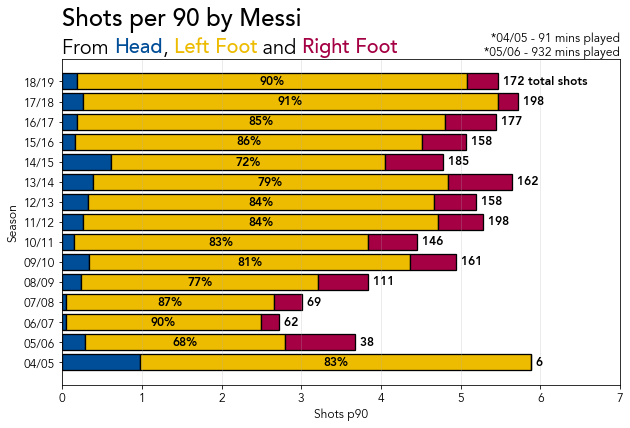

In [20]:
ind = list(reversed(np.arange(len(years))))

fig, ax = plt.subplots(figsize=(10,6))
p1 = ax.barh(ind, m_h / m_90_played,color='#004d98')
p2 = ax.barh(ind, m_lf / m_90_played,left=m_h / m_90_played,color='#edbb00')
p3 = ax.barh(ind, m_rf / m_90_played,left=(m_lf+m_h) / m_90_played,color='#a50044')

ax.set_yticks(ind)
ax.set_yticklabels(seasons)
ax.set_xlabel('Shots p90',fontsize=12)
ax.set_ylabel('Season',fontsize=12)
ax.set_xlim(0,7)

ymax = max(ax.get_ylim())
ax.text(0.0,1.08,'Shots per 90 by Messi',transform=ax.transAxes,va='bottom',fontsize=24,fontweight='medium')
htext(s="From <Head>, <Left Foot> and <Right Foot>",x=0,y=ymax,color='k',
      highlight_colors=['#004d98','#edbb00','#a50044'],fontsize=20,highlight_weights=['medium'],va='bottom')

tshotslabels = ['total shots']
for i in range(len(seasons)-1):
    tshotslabels.append('')

for i in range(len(ind)):
    ax.annotate('{0} {1}'.format((m_h + m_lf + m_rf)[i],tshotslabels[i]),
                    xy=(((m_h + m_lf + m_rf)[i] / m_90_played[i]), ind[i]), xytext=(5,0),
                    textcoords="offset points",
                    ha='left', va='center', fontsize=12, fontweight='bold')

ax.text(1.,1., '*04/05 - 91 mins played\n*05/06 - 932 mins played', ha='right', va='bottom', transform=ax.transAxes, 
        fontsize=12)

for i in range(len(ind)):
    ax.annotate('{:.0f}%'.format((m_lf[i]/sum([m_h[i],m_lf[i],m_rf[i]])) * 100),
                    xy=(((m_lf[i] / 2) + m_h[i]) / m_90_played[i], ind[i]), xytext=(0,0),
                    textcoords="offset points",
                    ha='center', va='center', fontsize=12, fontweight='bold')

ax.grid(axis='x',alpha=0.3)
    
plt.show()
#fig.savefig('example_plots/messi_shotsp90.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


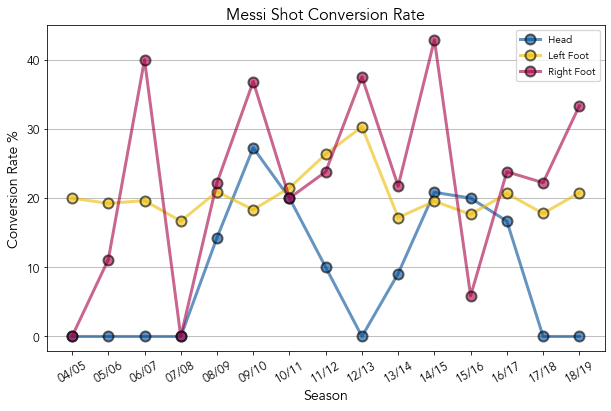

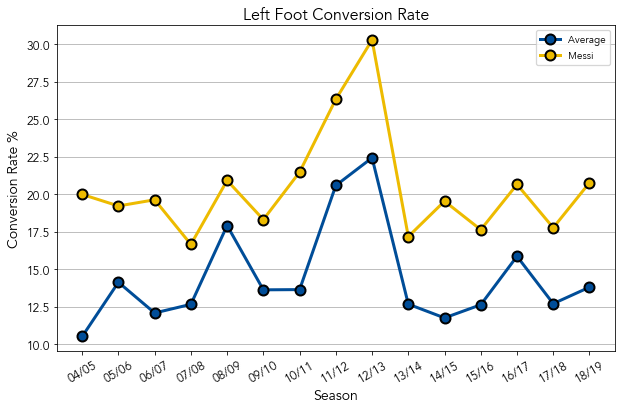

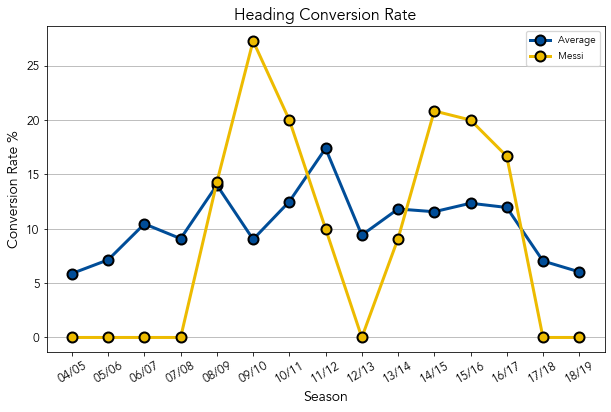

In [21]:
ind = list(reversed(np.arange(len(seasons))))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(m_h_g) / np.array(m_h)) * 100, '-o',mec='k',label='Head',alpha=0.6)
ax.plot(ind, (np.array(m_lf_g) / np.array(m_lf)) * 100, '-o',mec='k',label='Left Foot',alpha=0.6)
ax.plot(ind, np.nan_to_num((np.array(m_rf_g) / np.array(m_rf))) * 100, '-o',mec='k',label='Right Foot',alpha=0.6)
ax.set(xticks=ind,xlabel='Season',ylabel='Conversion Rate %',title='Messi Shot Conversion Rate')
ax.set_xticklabels(seasons,rotation=30)
ax.legend(loc='best')
ax.grid(axis='y')

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(lf_g) / np.array(lf)) * 100, '-o',mec='k',label='Average')
ax.plot(ind, (np.array(m_lf_g) / np.array(m_lf)) * 100, '-o',mec='k',label='Messi')
ax.set(xticks=ind,xlabel='Season',ylabel='Conversion Rate %',title='Left Foot Conversion Rate')
ax.set_xticklabels(seasons,rotation=30)
ax.legend(loc='best')
ax.grid(axis='y')

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, (np.array(h_g) / np.array(h)) * 100, '-o',mec='k',label='Average')
ax.plot(ind, (np.array(m_h_g) / np.array(m_h)) * 100, '-o',mec='k',label='Messi')
ax.set(xticks=ind,xlabel='Season',ylabel='Conversion Rate %',title='Heading Conversion Rate')
ax.set_xticklabels(seasons,rotation=30)
ax.legend(loc='best')
ax.grid(axis='y')

plt.show()

When comparing Messi to the average left foot conversion rate what I have done now seems unfair given the right foot is dominant for most players. Rather I should separate players into left foot and right foot dominance, which could be done by looking at all their shots or actions and looking at which is used more. Then I could compare Messi to just left footed players (however realistically this is just Barcelona left-footers) or compare to conversion rate of dominant foot.

In [22]:
m_xg_diff = []
m_xg_diff_h = []
m_xg_diff_lf = []
m_xg_diff_rf = []
b_xg_diff = []
for year in years:
    m_xg_diff.append(len(m_shots_seas[str(year)][m_shots_seas[str(year)]['outcome'] == 'Goal']) - 
    m_shots_seas[str(year)]['sb_xg'].sum())
    b_xg_diff.append(len(barca_shots_seas[str(year)][barca_shots_seas[str(year)]['outcome'] == 'Goal']) - 
    barca_shots_seas[str(year)]['sb_xg'].sum())
    
    m_xg_diff_h.append(len(m_seas_h[str(year)][(m_seas_h[str(year)]['outcome'] == 'Goal')]) - 
    m_seas_h[str(year)]['sb_xg'].sum())
    
    m_xg_diff_lf.append(len(m_seas_lf[str(year)][(m_seas_lf[str(year)]['outcome'] == 'Goal')]) - 
    m_seas_lf[str(year)]['sb_xg'].sum())
    
    m_xg_diff_rf.append(len(m_seas_rf[str(year)][(m_seas_rf[str(year)]['outcome'] == 'Goal')]) - 
    m_seas_rf[str(year)]['sb_xg'].sum())

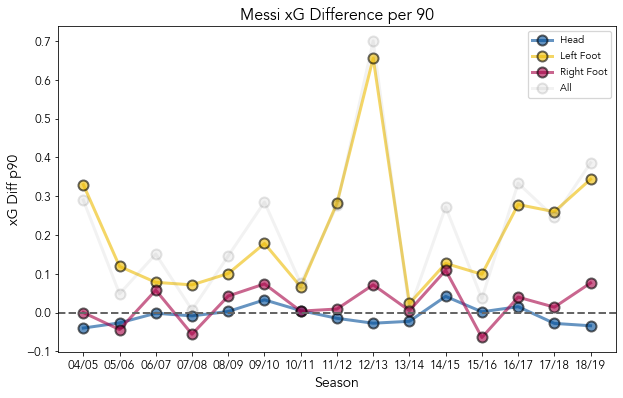

Exlcuding first two seasons
Avg with Head: -0.003
Avg with Left Foot: 0.197
Avg with Right Foot: 0.029


In [23]:
ind = list(reversed(np.arange(len(seasons))))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind, np.array(m_xg_diff_h) / np.array(m_90_played), '-o',mec='k',label='Head',alpha=0.6)
ax.plot(ind, np.array(m_xg_diff_lf) / np.array(m_90_played), '-o',mec='k',label='Left Foot',alpha=0.6)
ax.plot(ind, np.array(m_xg_diff_rf) / np.array(m_90_played), '-o',mec='k',label='Right Foot',alpha=0.6)
ax.plot(ind, np.array(m_xg_diff) / np.array(m_90_played), '-o',color='0.5',mec='k',label='All',alpha=0.1)
ax.axhline(0,color='0.4',ls='--',lw=2)
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='xG Diff p90',title='Messi xG Difference per 90')
ax.legend(loc='best')
plt.show()

print('Exlcuding first two seasons\nAvg with Head: {:.3f}'.format(np.mean((np.array(m_xg_diff_h) / np.array(m_90_played))[:-2])))
print('Avg with Left Foot: {:.3f}'.format(np.mean((np.array(m_xg_diff_lf) / np.array(m_90_played))[:-2])))
print('Avg with Right Foot: {:.3f}'.format(np.mean((np.array(m_xg_diff_rf) / np.array(m_90_played))[:-2])))

In [24]:
g_frac = []
xg_frac = []
for y in years:
    g_frac.append(len(m_shots_seas[str(y)][m_shots_seas[str(y)]['outcome'] == 'Goal']) / 
     len(barca_shots_seas[str(y)][barca_shots_seas[str(y)]['outcome'] == 'Goal']))
    xg_frac.append(m_shots_seas[str(y)]['sb_xg'].sum() / barca_shots_seas[str(y)]['sb_xg'].sum())

In [25]:
matches_played = []
for year in years:
    matches_played.append(len(event_data[str(year)]))

In [26]:
b_xg_diff_p90 = np.array(b_xg_diff) / np.array(matches_played)

In [27]:
m_xg_diff_p90 = np.array(m_xg_diff) / np.array(m_90_played)

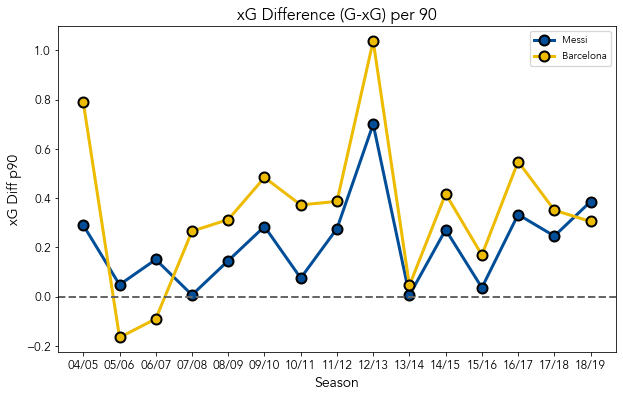

In [28]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_xg_diff_p90,'-o',mec='k',label='Messi')
ax.plot(ind,b_xg_diff_p90,'-o',mec='k',label='Barcelona')
ax.axhline(0,color='0.4',ls='--',lw=2)
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='xG Diff p90',title='xG Difference (G-xG) per 90')
ax.legend(loc='best')

plt.show()

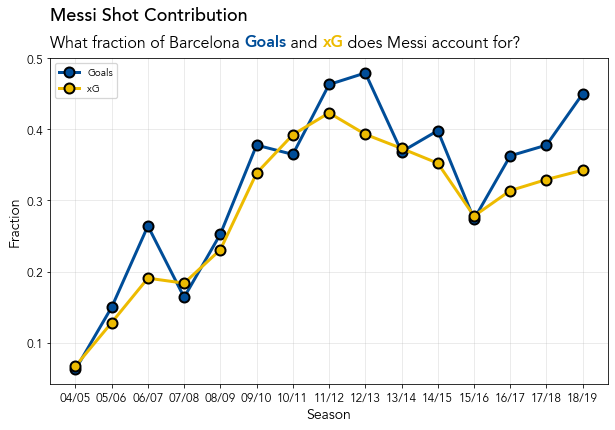

In [29]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,g_frac,'-o',mec='k',label='Goals')
ax.plot(ind,xg_frac,'-o',mec='k',label='xG')
ax.grid(alpha=0.3)
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction')
ax.legend(loc='best')
ax.text(0.0,1.1,'Messi Shot Contribution',ha='left',va='bottom',transform=ax.transAxes,fontsize=18,fontweight='semibold')
htext(s = 'What fraction of Barcelona <Goals> and <xG> does Messi account for?',x = -0.7, y = 0.51,color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=16,string_weight = 'regular',
      highlight_weights=['bold'])


plt.show()

It would be good to normlise this plot by minutes played.

## Passes

In [30]:
passes = {}
for year in years:
    passes[str(year)] = [imsb.get_pass(match) for match in event_data[str(year)]]

In [31]:
passes_seas = {}
for year in passes:
    passes_seas[str(year)] = pd.concat(passes[str(year)])
    passes_seas[str(year)].reset_index(inplace=True)

In [32]:
m_pass_seas = {}
m_pass_op_seas ={}
for year in years:
    m_pass_seas[str(year)] = passes_seas[str(year)][passes_seas[str(year)]['player'] == messi]
    m_pass_op_seas[str(year)] = passes_seas[str(year)][(passes_seas[str(year)]['player'] == messi)&
                                                       (passes_seas[str(year)]['pass_type'] == 'Standard')]

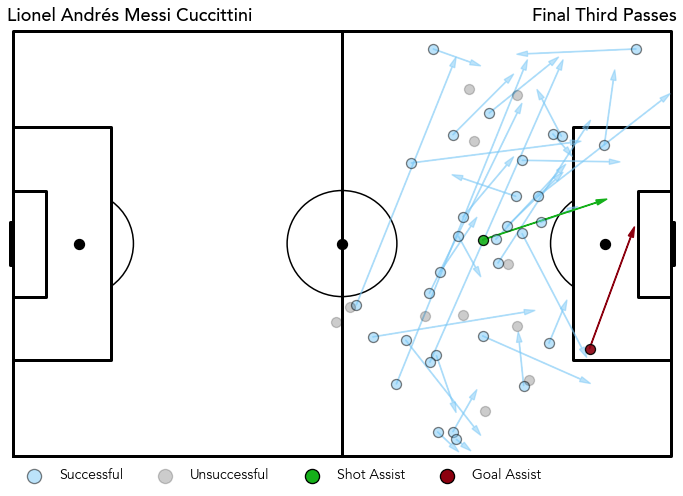

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1250775d0>)

In [33]:
imsb.pass_map_player(event_data['2015'][3],messi,'third')

### Pass Quantity

In [34]:
m_pass_op_tot = [len(m_pass_op_seas[str(i)]) for i in years]
m_ft_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['end_x'] >= 80.]) for i in years]
m_box_pass_op_tot = [len(m_pass_op_seas[str(i)][(m_pass_op_seas[str(i)]['end_x'] >= 102.)&
                                                (m_pass_op_seas[str(i)]['end_y'] >= 18.)&
                                                (m_pass_op_seas[str(i)]['end_y'] <= 62.)]) for i in years]

In [35]:
m_pass_p90 = np.array(m_pass_op_tot) / np.array(m_90_played)
m_ft_pass_p90 = np.array(m_ft_pass_op_tot) / np.array(m_90_played)
m_box_pass_p90 = np.array(m_box_pass_op_tot) / np.array(m_90_played)

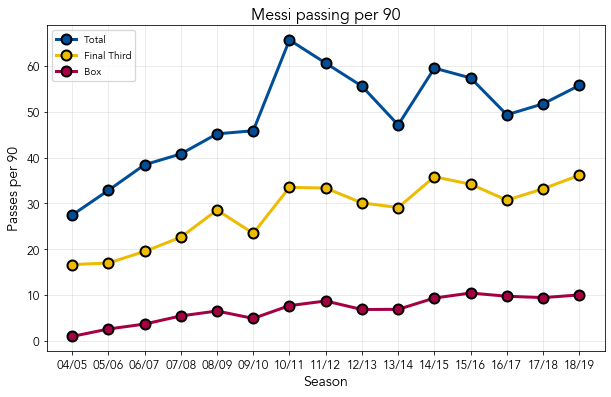

In [36]:
ind = np.flip(np.arange(len(years)))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_pass_p90,'-o',mec='k',label='Total')
ax.plot(ind,m_ft_pass_p90,'-o',mec='k',label='Final Third')
ax.plot(ind,m_box_pass_p90,'-o',mec='k',label='Box')

ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Passes per 90',title='Messi passing per 90')
ax.legend(loc=2)

ax.grid(True,alpha=0.3)

plt.show()

### What about types of passes?

In [37]:
m_thru_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['technique'] == 'Through Ball']) for i in years]
m_cross_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['cross'] == True]) for i in years]
m_switch_pass_op_tot = [len(m_pass_op_seas[str(i)][m_pass_op_seas[str(i)]['switch'] == True]) for i in years]

In [38]:
m_thru_p90 = np.array(m_thru_pass_op_tot) / np.array(m_90_played)
m_cross_p90 = np.array(m_cross_pass_op_tot) / np.array(m_90_played)
m_switch_p90 = np.array(m_switch_pass_op_tot) / np.array(m_90_played)

In [39]:
man_dates = [0,3+(8/12),7+(9/12),8+(10/12),9+(8/12),12+(9/12)]
man_names = ['Rijkaard','Guardiola','Vilanova','Martino','Enrique','Valverde']

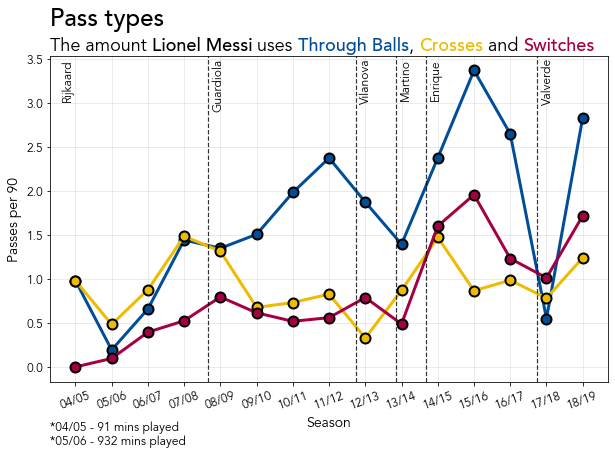

In [40]:
ind = np.flip(np.arange(len(years)))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,m_thru_p90,'-o',mec='k',label='Through Ball')
ax.plot(ind,m_cross_p90,'-o',mec='k',label='Cross')
ax.plot(ind,m_switch_p90,'-o',mec='k',label='Switch')

for i in range(len(man_dates)-1):
    ax.axvline(man_dates[i+1],0,1,c='k',ls='--',lw=1.2,alpha=0.8)
    ax.text(man_dates[i+1]+0.1,3.5,man_names[i+1],fontsize=12,ha='left',va='top',rotation=90)
    
ax.text(man_dates[0]-0.4,3.5,man_names[0],fontsize=12,ha='left',va='top',rotation=90)
    
ax.set(xticks=ind,xlabel='Season',ylabel='Passes per 90')
ax.set_xticklabels(seasons,rotation=20)

ymax = max(ax.get_ylim())
xmin = min(ax.get_xlim())
ax.text(0.0,1.15,'Pass types',ha='left', va='top',transform=ax.transAxes,fontsize=24,fontweight='semibold')
htext(s="The amount <{}> uses <Through Balls>, <Crosses> and <Switches>".format(nicknames[messi]),x=xmin,y=ymax,
     color='k',highlight_colors=['k','#004d98','#edbb00','#a50044'],fontsize=18,highlight_weights=['medium'])
ax.text(0.0, -0.12, '*04/05 - 91 mins played\n*05/06 - 932 mins played', ha='left', va='top', transform=ax.transAxes, fontsize=12)

ax.grid(True,alpha=0.3)

plt.show()
#fig.savefig('example_plots/messi_pass_type_p90.pdf',bbox_inches='tight')

In [41]:
m_pass_match = {}
for year in list(reversed(years)):
    m_pass_match[str(year)] = []
    for i in range(len(passes[str(year)])):
        m_pass_match[str(year)].append(passes[str(year)][i][(passes[str(year)][i]['player'] == messi)&
                                                     (passes[str(year)][i]['pass_type'] == 'Standard')])

In [42]:
m_pass_op_match = {}
for year in list(reversed(years)):
    m_pass_op_match[str(year)] = []
    for i in range(len(m_pass_match[str(year)])):
        m_pass_op_match[str(year)].append(len(m_pass_match[str(year)][i]))

In [43]:
m_pass_temp = [*m_pass_op_match.values()]
m_pass_all_df = pd.DataFrame([val for sublist in m_pass_temp for val in sublist])

In [44]:
roll_avg = m_pass_all_df.rolling(6).mean().values

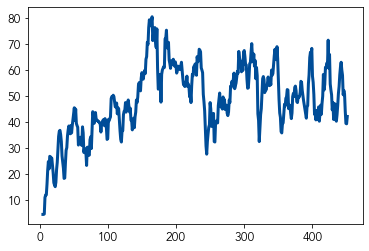

In [45]:
plt.plot(np.arange(len(roll_avg)),roll_avg)

### Expected Assists

In [46]:
m_pass_seas['2018'][(m_pass_seas['2018']['pass_type'] == 'Standard')&
                    (m_pass_seas['2018']['xA'].notna())][['cutback','technique','switch','cross']
                                                        ].apply(pd.value_counts)

,cutback,technique,switch,cross
False,70.0,NaN,74.0,70.0
True,6.0,NaN,2.0,6.0
Through Ball,NaN,23.0,NaN,NaN


In [47]:
m_xA = {}
for year in years:
    m_xA[str(year)] = m_pass_seas[str(year)][(m_pass_seas[str(year)]['pass_type'] == 'Standard')&
                    (m_pass_seas[str(year)]['xA'].notna())]

In [48]:
m_xA_std = np.array([m_xA[str(year)]['xA'].sum() for year in years])
m_xA_tb = np.array([m_xA[str(year)][m_xA[str(year)]['technique'] == 'Through Ball']['xA'].sum() for year in years])
m_xA_count = np.array([len(m_xA[str(year)]) for year in years])
m_xA_tb_count = np.array([len(m_xA[str(year)][m_xA[str(year)]['technique'] == 'Through Ball']) for year in years])

In [49]:
m_xA_tot = [m_pass_seas[str(year)]['xA'].sum() for year in years]
m_A_tot = [m_pass_seas[str(year)]['goal_assist'].sum() for year in years]

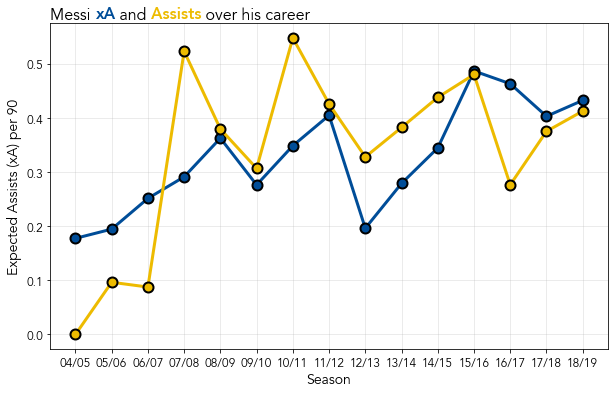

In [50]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,np.array(m_xA_tot) / np.array(m_90_played),'-o',mec='k',label='xA')
ax.plot(ind,np.array(m_A_tot) / np.array(m_90_played),'-o',mec='k',label='Assists')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Expected Assists (xA) per 90')
ax.grid(alpha=0.3)

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())

htext(s = 'Messi <xA> and <Assists> over his career',x = axx, y = axy,color = 'k', 
      highlight_colors = ['#004d98','#edbb00'],fontsize=16,string_weight = 'regular',
      highlight_weights=['bold'])

plt.show()

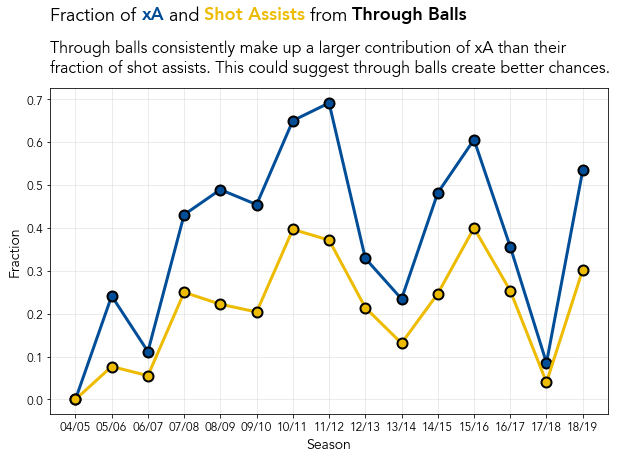

In [51]:
fig, ax = plt.subplots(figsize=(10,6))

years = list(range(2018,2003,-1))
ind = np.flip(np.arange(len(years)))

ax.plot(ind,m_xA_tb/m_xA_std,'-o',mec='k',label='xA')
ax.plot(ind,m_xA_tb_count/m_xA_count,'-o',mec='k',label='Assists')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction')
ax.grid(alpha=0.3)

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())

htext(s = 'Fraction of <xA> and <Shot Assists> from <Through Balls>',x = axx, y = axy+(axy*0.2),color = 'k', 
      highlight_colors = ['#004d98','#edbb00','k'],fontsize=18,string_weight = 'regular',
      highlight_weights=['bold'])
ax.text(axx,axy+(axy*0.05),'Through balls consistently make up a larger contribution of xA than their\nfraction of shot assists. This could suggest through balls create better chances.',fontsize=16)

plt.show()

This is likely because through balls are played into a position closer to the goal.

### Progressive Passes

Using this common Wyscout Progressive Pass definition of *'Forward passes that are 30m long when the pass starts in the team's own half or at least 10m in length in the opponent's half'*. However, I think I would like to make it distance to goal rather than just distance up te pitch (I don't know if this is the case in the original definition).

I have incorporated a Progressive Pass option into `importing_sb`.

#### Quantity of Progressive Passes

In [52]:
prog_pass_num = [len(m_pass_seas[str(year)][(m_pass_seas[str(year)]['pass_type'] == 'Standard')&
                         (m_pass_seas[str(year)]['progressive'] == True)]) for year in years]

In [53]:
prog_pass_num_p90 = np.array(prog_pass_num)/np.array(m_90_played)

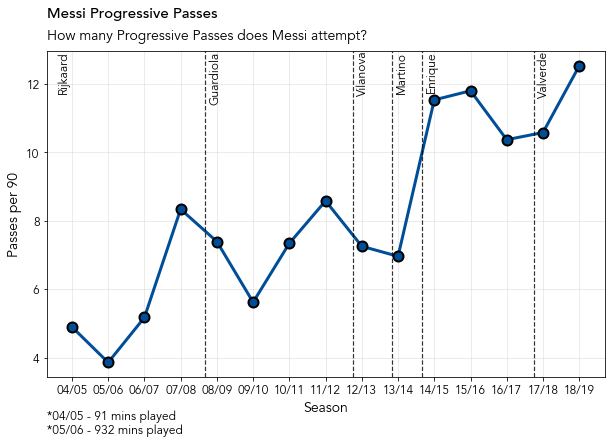

In [54]:
ind = np.flip(np.arange(len(years)))

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(ind,prog_pass_num_p90,'-o',mec='k')

axy = max(ax.get_ylim())
axx = min(ax.get_xlim())

# Add manager names
ax.text(man_dates[0]-0.4,axy,man_names[0],fontsize=12,ha='left',va='top',rotation=90)
for i in range(len(man_dates)-1):
    ax.axvline(man_dates[i+1],0,1,c='k',ls='--',lw=1.2,alpha=0.8)
    ax.text(man_dates[i+1]+0.1,axy,man_names[i+1],fontsize=12,ha='left',va='top',rotation=90)  
    
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Passes per 90')

ax.text(axx,axy+(0.1*axy),'Messi Progressive Passes',ha='left', va='top',fontsize=15,fontweight='semibold')
ax.text(axx,axy+(0.05*axy),'How many Progressive Passes does Messi attempt?',ha='left', va='top',fontsize=14)
ax.text(0.0, -0.1, '*04/05 - 91 mins played\n*05/06 - 932 mins played', ha='left', va='top', transform=ax.transAxes, fontsize=12)

ax.grid(True,alpha=0.3)

plt.show()
#fig.savefig('example_plots/messi_pass_type_p90.pdf',bbox_inches='tight')

In [55]:
df = m_pass_seas['2018'][(m_pass_seas['2018']['pass_type'] == 'Standard')&
                         (m_pass_seas['2018']['progressive'] == True)]

In [56]:
df[['cross','cutback','switch','technique']].apply(pd.value_counts)

,cross,cutback,switch,technique
False,359.0,359.0,376.0,NaN
True,35.0,35.0,18.0,NaN
Through Ball,NaN,NaN,NaN,67.0


## Carries and Dribbles

In [58]:
m_car_prog_18 = imsb.get_carry_prog(event_data_18,find_success=True,player=messi)

In [59]:
m_car_prog_18.head()

,index,event_id,period,minute,second,type,pos_team,play_pattern,team,player,...,end_y,carry_dist,outcome,pass_outcome,shot_outcome,dribble_outcome,xG,xA,outcome_id,related_events
115,458,1fa2f27a-6fb7-478f-aaad-f2fdfbb6030d,1,8,41,Carry,Barcelona,From Throw In,Barcelona,Lionel Andrés Messi Cuccittini,...,58.0,14.035669,Unsuccessful,None,None,None,NaN,NaN,67bec08e-19cf-4d62-a6b8-816280ed1f64,"[1251d5ce-9d14-4459-8b32-6d13d774c5fe, 67bec08..."
231,914,4fb91a0e-dc65-49a6-9f85-3f9c03aab8b1,1,20,10,Carry,Barcelona,Regular Play,Barcelona,Lionel Andrés Messi Cuccittini,...,55.0,9.848858,Successful,Complete,None,None,NaN,NaN,81bb2736-d1a3-476f-91b8-5eebbdf141fa,"[76607543-465b-4ce6-b5dc-e48e3f595081, 81bb273..."
414,1661,eeceecfa-c9e0-4cde-8ea0-2c2f762792fe,1,36,7,Carry,Barcelona,Regular Play,Barcelona,Lionel Andrés Messi Cuccittini,...,55.0,23.000000,Unsuccessful,Incomplete,None,None,NaN,NaN,f95b2edc-7c0d-4c61-bf9f-baa56e60e403,"[7ca5a931-7b9d-4863-a707-aab4d07e3da0, 98f092f..."
460,1898,a091c088-5b47-4b4e-90b5-33665e93bad4,1,44,53,Carry,Barcelona,Regular Play,Barcelona,Lionel Andrés Messi Cuccittini,...,59.0,8.544004,Unsuccessful,Incomplete,None,None,NaN,NaN,a495422c-2d80-454b-8ca3-cce03e70004b,"[a495422c-2d80-454b-8ca3-cce03e70004b, cbcc25e..."
523,2161,68f67c0c-ecb3-469f-a0e8-4afbcbf346c3,2,48,44,Carry,Barcelona,Regular Play,Barcelona,Lionel Andrés Messi Cuccittini,...,60.0,8.602325,Successful,None,None,None,NaN,NaN,2dc488f3-3aee-4215-aa58-b1bb71fe7a57,"[0fc23fb7-6a1e-4d18-8b73-27dd3e7218b2, 2019ec5..."


In [60]:
print(m_car_prog_18[m_car_prog_18['xA'].notna()].xA.sum())
print(m_car_prog_18[m_car_prog_18['xG'].notna()].xG.sum())

3.7248932669999997
3.7184249790000004


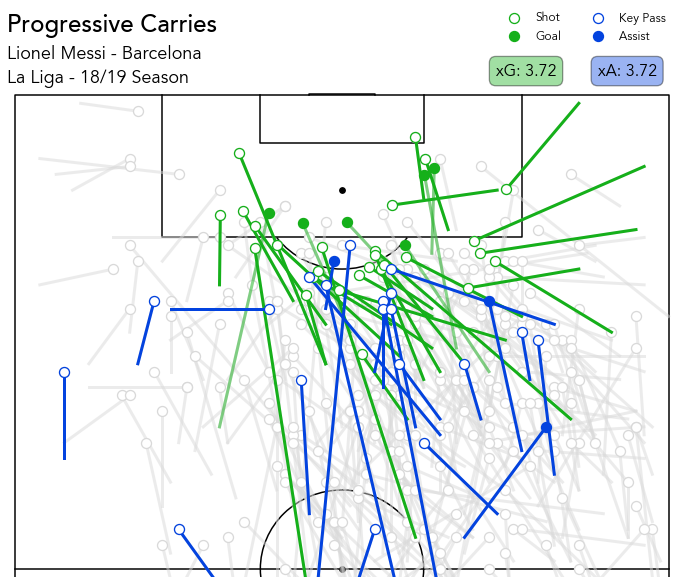

In [61]:
fig, ax = dp.draw_pitch('w','k','v','h')

m_car_s = m_car_prog_18[m_car_prog_18['outcome'] == 'Successful']
m_car_u = m_car_prog_18[m_car_prog_18['outcome'] == 'Unsuccessful']
m_car_shot = m_car_prog_18[(m_car_prog_18['shot_outcome'] != 'Goal')&(m_car_prog_18['shot_outcome'].notnull())]
m_car_goal = m_car_prog_18[(m_car_prog_18['shot_outcome'] == 'Goal')]
m_car_pass = m_car_s[(m_car_s['pass_outcome'].notnull())]
m_car_sa = m_car_pass[(m_car_pass['pass_outcome'] == 'Shot Assist')]
m_car_ga = m_car_pass[(m_car_pass['pass_outcome'] == 'Goal Assist')]
m_car_drib = m_car_s[(m_car_s['dribble_outcome'].notnull())]

xA_tot = m_car_prog_18[m_car_prog_18['xA'].notna()].xA.sum()
xG_tot = m_car_prog_18[m_car_prog_18['xG'].notna()].xG.sum()

xs = m_car_s['x'].values
ys = m_car_s['y'].values
xse = m_car_s['end_x'].values
yse = m_car_s['end_y'].values

xsh = m_car_shot['x'].values
ysh = m_car_shot['y'].values
xshe = m_car_shot['end_x'].values
yshe = m_car_shot['end_y'].values

xg = m_car_goal['x'].values
yg = m_car_goal['y'].values
xge = m_car_goal['end_x'].values
yge = m_car_goal['end_y'].values

xsa = m_car_sa['x'].values
ysa = m_car_sa['y'].values
xsae = m_car_sa['end_x'].values
ysae = m_car_sa['end_y'].values

xga = m_car_ga['x'].values
yga = m_car_ga['y'].values
xgae = m_car_ga['end_x'].values
ygae = m_car_ga['end_y'].values

xd = m_car_drib['x'].values
yd = m_car_drib['y'].values
xde = m_car_drib['end_x'].values
yde = m_car_drib['end_y'].values

zo=100
ax.plot([ys,yse],[xs,xse],'0.85',alpha=0.5,zorder=zo)
ax.scatter(yse,xse,s=100,facecolor='w',edgecolor='0.85',zorder=zo+1)
ax.plot([ysh,yshe],[xsh,xshe],'xkcd:green',alpha=1,zorder=zo+2)
ax.scatter(yshe,xshe,s=100,facecolor='w',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([yg,yge],[xg,xge],'xkcd:green',alpha=0.5,zorder=zo+2)
ax.scatter(yge,xge,s=100,facecolor='xkcd:green',edgecolor='xkcd:green',zorder=zo+3)
ax.plot([ysa,ysae],[xsa,xsae],'xkcd:blue',alpha=1,zorder=zo+2)
ax.scatter(ysae,xsae,s=100,facecolor='w',edgecolor='xkcd:blue',zorder=zo+3)
ax.plot([yga,ygae],[xga,xgae],'xkcd:blue',alpha=1,zorder=zo+2)
ax.scatter(ygae,xgae,s=100,facecolor='xkcd:blue',edgecolor='xkcd:blue',zorder=zo+3)

ax.text(0.0,1.1,'Progressive Carries',transform=ax.transAxes,ha='left',va='bottom',fontsize=24,
        fontweight='semibold',zorder=zo)
ax.text(0.0,1.05,nicknames[messi] + " - Barcelona",transform=ax.transAxes,ha='left',va='bottom',fontsize=18,
        zorder=zo)
ax.text(0.0,1.,'La Liga - 18/19 Season',transform=ax.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo,)

ax.scatter(-100,-100,s=100,facecolor='w',edgecolor='xkcd:green',zorder=zo+3,label='Shot')
ax.scatter(-100,-100,s=100,facecolor='xkcd:green',edgecolor='xkcd:green',zorder=zo+3,label='Goal')
ax.scatter(-100,-100,s=100,facecolor='w',edgecolor='xkcd:blue',zorder=zo+3,label='Key Pass')
ax.scatter(-100,-100,s=100,facecolor='xkcd:blue',edgecolor='xkcd:blue',zorder=zo+3,label='Assist')

ax.legend(loc=4,bbox_to_anchor=(1.0,1.07),ncol=2,frameon=False,fontsize=12,framealpha=0,facecolor=None)

ax.text(0.82,1.025,'xG: {:.2f}'.format(xG_tot),transform=ax.transAxes,fontsize=16,
        bbox=dict(boxstyle='round,pad=0.4',facecolor='xkcd:green',edgecolor='k',alpha=0.4),ha='right',zorder=zo)
ax.text(0.97,1.025,'xA: {:.2f}'.format(xA_tot),transform=ax.transAxes,fontsize=16,
        bbox=dict(boxstyle='round,pad=0.4',facecolor='xkcd:blue',edgecolor='k',alpha=0.4),ha='right',zorder=zo)

plt.show()
#fig.savefig('example_plots/carry_map.pdf',bbox_inches='tight')

In [62]:
m_carries = {}
for year in years:
    m_carries[str(year)] = [imsb.get_carry_prog(match,find_success=True,player=messi) for match in event_data[str(year)]]

In [63]:
m_car_seas = {}
m_car_seas_suc = {}
for year in m_carries:
    m_car_seas[str(year)] = pd.concat(m_carries[str(year)])
    m_car_seas[str(year)].reset_index(inplace=True)
    m_car_seas_suc[str(year)] = m_car_seas[str(year)][m_car_seas[str(year)]['outcome'] == 'Successful']

In [64]:
m_car_seas_box = {}
m_car_seas_box_suc = {}
for year in m_carries:
    m_car_seas_box[str(year)] = m_car_seas[str(year)][(m_car_seas[str(year)]['end_x'] >= 102)&(m_car_seas[str(year)]['end_y'] >= 18)&(m_car_seas[str(year)]['end_y'] <= 62)&((m_car_seas[str(year)]['x'] <= 102)|(m_car_seas[str(year)]['y'] <= 18)|(m_car_seas[str(year)]['y'] >= 62))]
    m_car_seas_box_suc[str(year)] = m_car_seas_box[str(year)][m_car_seas_box[str(year)]['outcome'] == 'Successful']

In [65]:
car_p_suc_frac = np.array([(len(m_car_seas_suc[str(years[i])]) / len(m_car_seas[str(years[i])])) for i in range(len(years))])
car_p_tot_p90 = np.array([(len(m_car_seas[str(years[i])]) / m_90_played[i]) for i in range(len(years))])
car_p_suc_p90 = np.array([(len(m_car_seas_suc[str(years[i])]) / m_90_played[i]) for i in range(len(years))])
car_p_tot_dist = np.array([m_car_seas[str(years[i])]['carry_dist'].mean() for i in range(len(years))])
car_p_suc_dist = np.array([m_car_seas_suc[str(years[i])]['carry_dist'].mean() for i in range(len(years))])

car_p_pass_frac = np.array([len(m_car_seas[str(years[i])][m_car_seas[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas[str(years[i])]) for i in range(len(years))])
car_p_shot_frac = np.array([len(m_car_seas[str(years[i])][m_car_seas[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas[str(years[i])]) for i in range(len(years))])
car_p_drib_frac = np.array([len(m_car_seas[str(years[i])][m_car_seas[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas[str(years[i])]) for i in range(len(years))])
car_p_pass_frac_s = np.array([len(m_car_seas_suc[str(years[i])][m_car_seas_suc[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas_suc[str(years[i])]) for i in range(len(years))])
car_p_shot_frac_s = np.array([len(m_car_seas_suc[str(years[i])][m_car_seas_suc[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas_suc[str(years[i])]) for i in range(len(years))])
car_p_drib_frac_s = np.array([len(m_car_seas_suc[str(years[i])][m_car_seas_suc[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas_suc[str(years[i])]) for i in range(len(years))])

car_p_xG = np.array([m_car_seas[str(years[i])]['xG'].sum() for i in range(len(years))])
car_p_xA = np.array([m_car_seas[str(years[i])]['xA'].sum() for i in range(len(years))])
car_p_xG_p90 = np.array([m_car_seas[str(years[i])]['xG'].sum() / m_90_played[i] for i in range(len(years))])
car_p_xA_p90 = np.array([m_car_seas[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])

car_p_tot_box = np.array([len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_suc_box = np.array([len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])
car_p_tot_box_p90 = car_p_tot_box / np.array(m_90_played)
car_p_suc_box_p90 = car_p_suc_box / np.array(m_90_played)

car_p_pass_box = np.array([len(m_car_seas_box[str(years[i])][m_car_seas_box[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_shot_box = np.array([len(m_car_seas_box[str(years[i])][m_car_seas_box[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_drib_box = np.array([len(m_car_seas_box[str(years[i])][m_car_seas_box[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas_box[str(years[i])]) for i in range(len(years))])
car_p_pass_box_s = np.array([len(m_car_seas_box_suc[str(years[i])][m_car_seas_box_suc[str(years[i])]['pass_outcome'].notna()]) / len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])
car_p_shot_box_s = np.array([len(m_car_seas_box_suc[str(years[i])][m_car_seas_box_suc[str(years[i])]['shot_outcome'].notna()]) / len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])
car_p_drib_box_s = np.array([len(m_car_seas_box_suc[str(years[i])][m_car_seas_box_suc[str(years[i])]['dribble_outcome'].notna()]) / len(m_car_seas_box_suc[str(years[i])]) for i in range(len(years))])


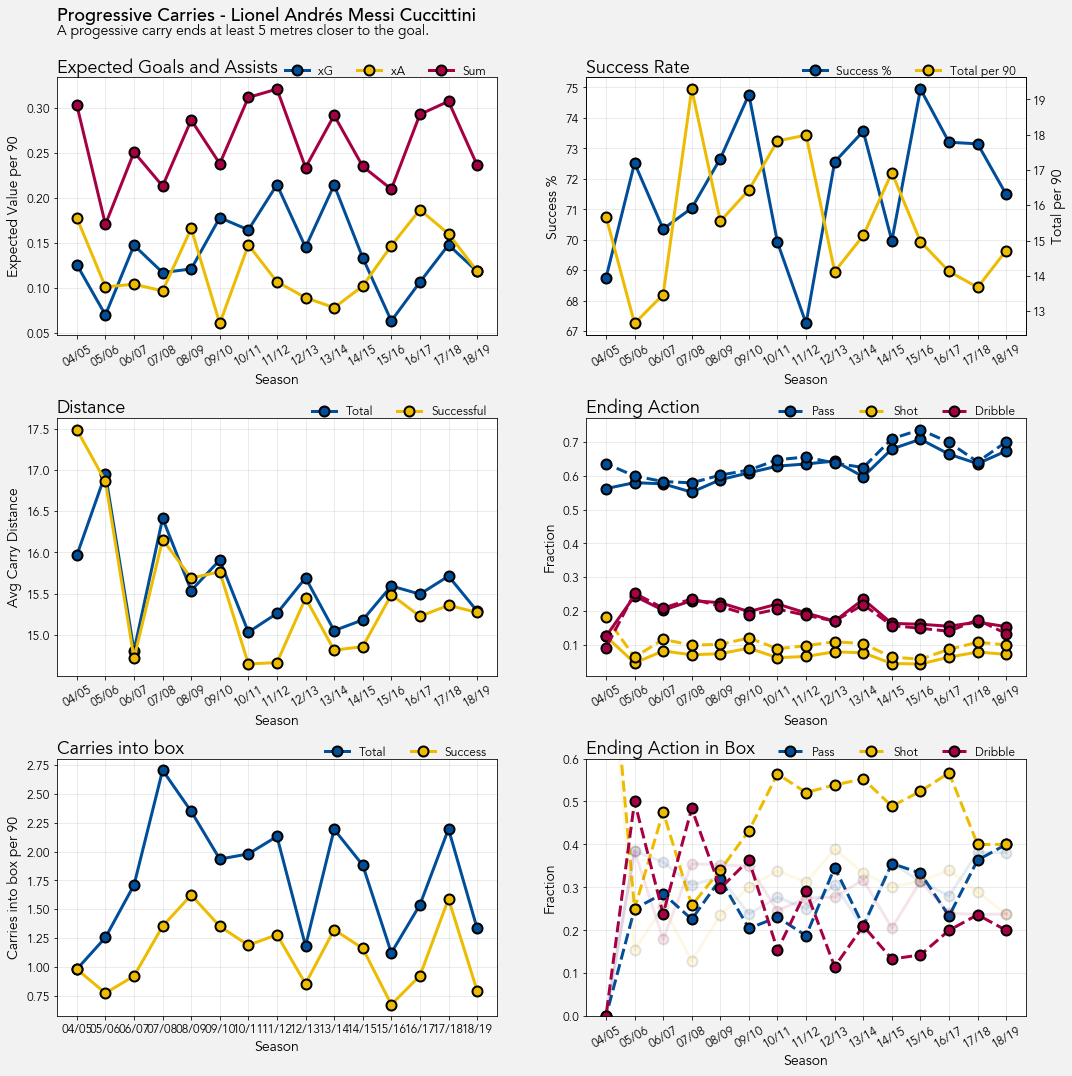

In [66]:
import matplotlib as mpl

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2,sharex='row',figsize=(15,15),facecolor='0.95')

ind = np.flip((np.arange(len(years))))

zo=100

ax1.text(0.0,1.2,'Progressive Carries - ' + messi,transform=ax1.transAxes,ha='left',va='bottom',fontsize=18,fontweight='semibold',zorder=zo)
ax1.text(0.0,1.15,'A progessive carry ends at least 5 metres closer to the goal.',transform=ax1.transAxes,ha='left',va='bottom',fontsize=14,zorder=zo)

ax1.plot(ind, car_p_xG_p90,'-o',c='#004d98',mec='k',label='xG')
ax1.plot(ind, car_p_xA_p90,'-o',c='#edbb00',mec='k',label='xA')
ax1.plot(ind, car_p_xG_p90+car_p_xA_p90,'-o',c='#a50044',mec='k',label='Sum')
ax1.set(xticks=ind,xlabel='Season',ylabel='Expected Value per 90')
ax1.set_xticklabels(seasons,rotation=30)
ax1.legend(loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax1.text(0.0,1.0,'Expected Goals and Assists',transform=ax1.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax1.grid(alpha=0.3)

suc = ax2.plot(ind, car_p_suc_frac*100,'-o',c='#004d98',mec='k')
ax2r = ax2.twinx()
tot = ax2r.plot(ind, car_p_tot_p90,'-o',c='#edbb00',mec='k')
ax2.set(xlabel='Season',ylabel='Success %')
ax2.set_xticklabels(seasons,rotation=30)
ax2r.set(ylabel='Total per 90')
ax2.legend([suc[0],tot[0]],['Success %','Total per 90'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax2.text(0.0,1.0,'Success Rate',transform=ax2.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax2.grid(alpha=0.3)

tot = ax3.plot(ind, car_p_tot_dist,'-o',c='#004d98',mec='k')
suc = ax3.plot(ind, car_p_suc_dist,'-o',c='#edbb00',mec='k')
ax3.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Avg Carry Distance')
ax3.set_xticklabels(seasons,rotation=30)
ax3.legend([tot[0],suc[0]],['Total','Successful'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax3.text(0.0,1.0,'Distance',transform=ax3.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax3.grid(alpha=0.3)

pas = ax4.plot(ind, car_p_pass_frac,'-o',c='#004d98',mec='k')
pas = ax4.plot(ind, car_p_pass_frac_s,'--o',c='#004d98',mec='k')
shot = ax4.plot(ind, car_p_shot_frac,'-o',c='#edbb00',mec='k')
shot = ax4.plot(ind, car_p_shot_frac_s,'--o',c='#edbb00',mec='k')
drib = ax4.plot(ind, car_p_drib_frac,'-o',c='#a50044',mec='k')
drib = ax4.plot(ind, car_p_drib_frac_s,'--o',c='#a50044',mec='k')
ax4.set(xlabel='Season',ylabel='Fraction')
ax4.set_xticklabels(seasons,rotation=30)
ax4.legend([pas[0],shot[0],drib[0]],['Pass','Shot','Dribble'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax4.text(0.0,1.0,'Ending Action',transform=ax4.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax4.grid(alpha=0.3)

ax5.plot(ind, car_p_tot_box_p90,'-o',c='#004d98',mec='k',label='Total')
ax5.plot(ind, car_p_suc_box_p90,'-o',c='#edbb00',mec='k',label='Success')
ax5.set(xticks=ind,xlabel='Season',ylabel='Carries into box per 90')
ax4.set_xticklabels(seasons,rotation=30)
ax5.legend(loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax5.text(0.0,1.0,'Carries into box',transform=ax5.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax5.grid(alpha=0.3)

pas = ax6.plot(ind, car_p_pass_box,'-o',c='#004d98',mec='k',alpha=0.1)
pas = ax6.plot(ind, car_p_pass_box_s,'--o',c='#004d98',mec='k')
shot = ax6.plot(ind, car_p_shot_box,'-o',c='#edbb00',mec='k',alpha=0.1)
shot = ax6.plot(ind, car_p_shot_box_s,'--o',c='#edbb00',mec='k')
drib = ax6.plot(ind, car_p_drib_box,'-o',c='#a50044',mec='k',alpha=0.1)
drib = ax6.plot(ind, car_p_drib_box_s,'--o',c='#a50044',mec='k')
ax6.set(xlabel='Season',ylabel='Fraction',ylim=(0.0,0.6))
ax6.set_xticklabels(seasons,rotation=30)
ax6.legend([pas[0],shot[0],drib[0]],['Pass','Shot','Dribble'],loc=1,bbox_to_anchor=(1.0,1.09),ncol=3,frameon=False,fontsize=12)
ax6.text(0.0,1.0,'Ending Action in Box',transform=ax6.transAxes,ha='left',va='bottom',fontsize=18,zorder=zo)
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()
#fig.savefig('example_plots/messi_carries.pdf',bbox_inches='tight')

In [68]:
sum_rescale = (car_p_xG_p90+car_p_xA_p90-min(car_p_xG_p90+car_p_xA_p90)) / (max(car_p_xG_p90+car_p_xA_p90)-min(car_p_xG_p90+car_p_xA_p90))
dist_tot_rescale = (car_p_tot_dist-min(car_p_tot_dist)) / (max(car_p_tot_dist)-min(car_p_tot_dist))
dist_tot_rescale_flip = (car_p_tot_dist-max(car_p_tot_dist)) / (min(car_p_tot_dist)-max(car_p_tot_dist))
dist_suc_rescale = (car_p_suc_dist-min(car_p_suc_dist)) / (max(car_p_suc_dist)-min(car_p_suc_dist))
dist_suc_rescale_flip = (car_p_suc_dist-max(car_p_suc_dist)) / (min(car_p_suc_dist)-max(car_p_suc_dist))

While it is quite difficult to see whether any of these facets of carries affect the total offensive contribution (xG + xA), something to note is the relationship between Total Offensive Contribution and the average distance of a carry. It appears that their behaviours are opposite. **Increases** in carry distance **decrease** xG + xA.

Typically it is seen that a greater carry distance is a good thing as it means more progress towards the opposition goal. However, in terms of the xG + xA output of Messi, the opposite is true.

Below is the plot of rescaled xG + xA and the Average Carry Distance which has also been flipped (such that the minimum carry distances are now maximum, just so the relationship between the two is clearer).

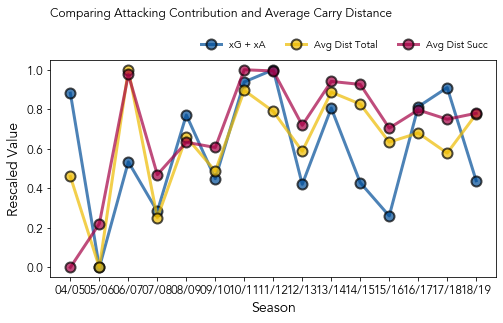

In [69]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(ind,sum_rescale,'-o',alpha=0.7,mec='k',label='xG + xA')
ax.plot(ind,dist_tot_rescale_flip,'-o',alpha=0.7,mec='k',label='Avg Dist Total')
ax.plot(ind,dist_suc_rescale_flip,'-o',alpha=0.7,mec='k',label='Avg Dist Succ')

ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Rescaled Value')
ax.text(0,1.2,'Comparing Attacking Contribution and Average Carry Distance',transform=ax.transAxes,fontsize=12)
ax.legend(loc=4,bbox_to_anchor=(1.0,1.0),ncol=3,frameon=False,fontsize=10)
plt.show()

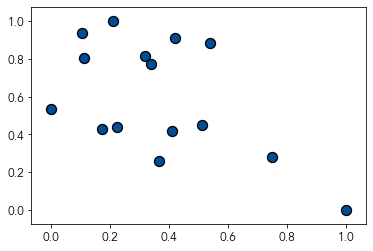

In [70]:
plt.scatter(dist_tot_rescale,sum_rescale)

Looking at this scatter plot, it doesn't appear like there is much relationship between the Average Carry Distance and the Attacking Contribution (xG + xA); especially when that two largest average distance seasons are ignored.

## Differences between Passes and Passes After Carries

### Using Progressive Carries

In [71]:
m_pass_op_seas['2015']['event_id'].values[0]
pass_c = m_car_seas['2015'][m_car_seas['2015']['pass_outcome'].notna()]

In [72]:
pass_c = {}
pass_nc = {}
for year in years:
    cond_list = []
    pass_c[str(year)] = m_car_seas[str(year)][m_car_seas[str(year)]['pass_outcome'].notna()]
    for i in m_pass_op_seas[str(year)]['event_id'].values:
        val = i not in pass_c[str(year)]['outcome_id'].values
        cond_list.append(val)
    pass_nc[str(year)] = m_pass_op_seas[str(year)][cond_list]

In [73]:
# Excluding 04/05
years = list(range(2018,2004,-1))

pass_nc_ratio = np.array([len(pass_nc[str(years[i])][pass_nc[str(years[i])]['outcome'] == 'Complete']) / len(pass_nc[str(years[i])]) for i in range(len(years))])
pass_c_ratio = np.array([len(pass_c[str(years[i])][pass_c[str(years[i])]['pass_outcome'] != 'Incomplete']) / len(pass_c[str(years[i])]) for i in range(len(years))])
pass_ratio = np.array([len(pass_c[str(years[i])]) / (len(pass_nc[str(years[i])]) + len(pass_c[str(years[i])])) for i in range(len(years))])

pass_nc_xA = np.array([pass_nc[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])
pass_c_xA = np.array([pass_c[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])

From the plot below we see that passes which follow a carry contribute more to the total xA than their proportion of total passes would suggest if passes following a carry and not were the same. However, this is all open play passes. I think it would be fairer to compare to something like Progressive Passes.

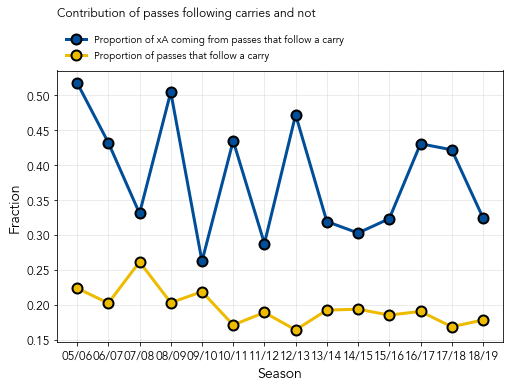

In [74]:
fig, ax = plt.subplots(figsize=(8,5))

ind = np.flip((np.arange(len(years))))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06']

ax.plot(ind, pass_c_xA / (pass_nc_xA + pass_c_xA),'-o',mec='k',label='Proportion of xA coming from passes that follow a carry')
ax.plot(ind, pass_ratio,'-o',mec='k',label='Proportion of passes that follow a carry')
ax.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction')
ax.grid(alpha=0.3)

ax.legend(loc=3,bbox_to_anchor=(0.0,1.0),frameon=False)
ax.text(0.0,1.2,'Contribution of passes following carries and not',transform=ax.transAxes,fontsize=12)
plt.show()

### Using final third passes and progressive carries

In [75]:
pass_c_ft = {}
pass_nc_ft = {}
for year in years:
    from_carry_cond_list = []
    not_from_carry_cond_list = []
    pass_from_carry = m_car_seas[str(year)][m_car_seas[str(year)]['pass_outcome'].notna()]
    for i in m_pass_op_seas[str(year)]['event_id'].values:
        from_carry = i in pass_from_carry['outcome_id'].values
        from_carry_cond_list.append(from_carry)
        not_from_carry = i not in pass_from_carry['outcome_id'].values
        not_from_carry_cond_list.append(not_from_carry)
    pass_nc_ft[str(year)] = m_pass_op_seas[str(year)][(not_from_carry_cond_list)&(m_pass_op_seas[str(year)]['end_x'] >= 80)]
    pass_c_ft[str(year)] = m_pass_op_seas[str(year)][(from_carry_cond_list)&(m_pass_op_seas[str(year)]['end_x'] >= 80)]

In [76]:
print(pass_c_ft['2015']['xA'].sum())
print(pass_nc_ft['2015']['xA'].sum())
print(pass_c['2015']['xA'].sum())
print(pass_nc['2015']['xA'].sum())

4.577668559000001
9.590408934
4.577668559
9.590408934


We see that there is no difference between the xA for all passes and just passes into the final third. Therefore, I believe it is more correct to compare to final third passes rather than just all passes (at least for 15/16). 

Also note here that I have also used passes following carries into the final third, rather than all passes following carries.

In [77]:
# Excluding 04/05
years = list(range(2018,2004,-1))

pass_ft_ratio = np.array([len(pass_c_ft[str(years[i])]) / (len(pass_nc_ft[str(years[i])]) + len(pass_c_ft[str(years[i])])) for i in range(len(years))])

pass_nc_ft_xA_p90 = np.array([pass_nc_ft[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])
pass_c_ft_xA_p90 = np.array([pass_c_ft[str(years[i])]['xA'].sum() / m_90_played[i] for i in range(len(years))])

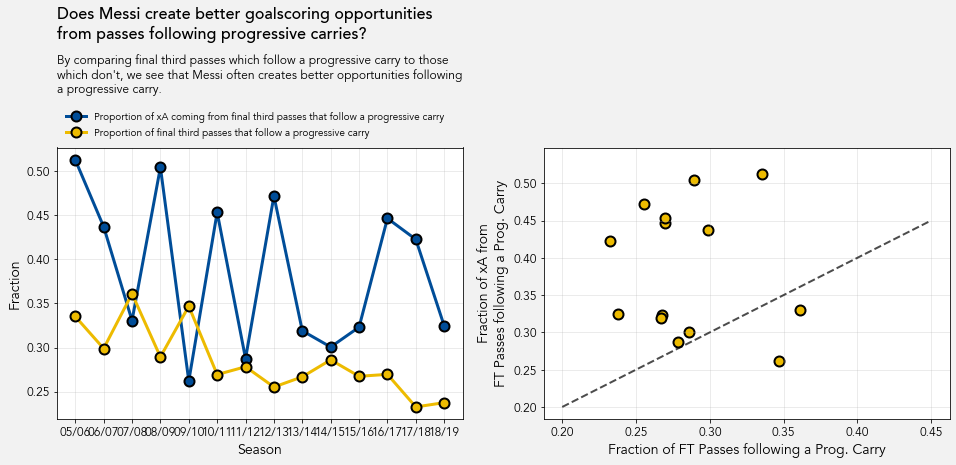

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5),facecolor='0.95')

ind = np.flip((np.arange(len(years))))
seasons = ['18/19','17/18','16/17','15/16','14/15','13/14','12/13','11/12','10/11','09/10','08/09','07/08','06/07','05/06']

ax1.plot(ind, pass_c_ft_xA_p90 / (pass_nc_ft_xA_p90 + pass_c_ft_xA_p90),'-o',mec='k',label='Proportion of xA coming from final third passes that follow a progressive carry')
ax1.plot(ind, pass_ft_ratio,'-o',mec='k',label='Proportion of final third passes that follow a progressive carry')
ax1.set(xticks=ind,xticklabels=seasons,xlabel='Season',ylabel='Fraction')
ax1.grid(alpha=0.3)
ax1.legend(loc=3,bbox_to_anchor=(0.0,1.0),frameon=False)
ax1.text(0.0,1.4,'Does Messi create better goalscoring opportunities\nfrom passes following progressive carries?',transform=ax1.transAxes,fontsize=16,fontweight='semibold')
ax1.text(0.0,1.2,'By comparing final third passes which follow a progressive carry to those\nwhich don\'t, we see that Messi often creates better opportunities following\na progressive carry.',transform=ax1.transAxes,fontsize=12)

ax2.scatter(pass_ft_ratio,pass_c_ft_xA_p90 / (pass_nc_ft_xA_p90 + pass_c_ft_xA_p90),c='#edbb00',edgecolors='k',linewidths=2)
ax2.plot([0.2,0.45],[0.2,0.45],'--k',lw=2,alpha=0.7)
ax2.set(xlabel='Fraction of FT Passes following a Prog. Carry',ylabel='Fraction of xA from\nFT Passes following a Prog. Carry')
ax2.grid(alpha=0.3)

plt.show()

In [79]:
car_p_ft = {}
for year in years:
    car_p_ft_cond_list = []
    for i in m_car_seas[str(year)]['outcome_id'].values:
        car_p_ft_cond = i in pass_c_ft[str(year)]['event_id'].values
        car_p_ft_cond_list.append(car_p_ft_cond)
    car_p_ft[str(year)] = m_car_seas[str(year)][car_p_ft_cond_list]

In [80]:
car_s = car_p_ft['2015'][car_p_ft['2015']['pass_outcome'] == 'Successful']
car_u = car_p_ft['2015'][car_p_ft['2015']['pass_outcome'] == 'Unsuccessful']
car_sa = car_p_ft['2015'][(car_p_ft['2015']['pass_outcome'] == 'Shot Assist')]
car_ga = car_p_ft['2015'][(car_p_ft['2015']['pass_outcome'] == 'Goal Assist')]
pass_s = pass_c_ft['2015'][(pass_c_ft['2015']['outcome'] == 'Complete')&
                           (pass_c_ft['2015']['shot_assist'].isnull())&
                          (pass_c_ft['2015']['goal_assist'].isnull())]
pass_u = pass_c_ft['2015'][pass_c_ft['2015']['outcome'] == 'Incomplete']
pass_sa = pass_c_ft['2015'][pass_c_ft['2015']['shot_assist'].notnull()]
pass_ga = pass_c_ft['2015'][pass_c_ft['2015']['goal_assist'].notnull()]

In [81]:
pass_c_ft['2015'].outcome.value_counts()

Complete        214
Incomplete       56
Pass Offside     11
Out               4
Name: outcome, dtype: int64

I need to be careful here as my pass dataset includes *Pass Offside* outcome which is listed as an *Unsuccessful* outcome in the carries but I don't think this is really fair. In the future I should further filter my dataset to exclude the *Pass Offside* outcome.

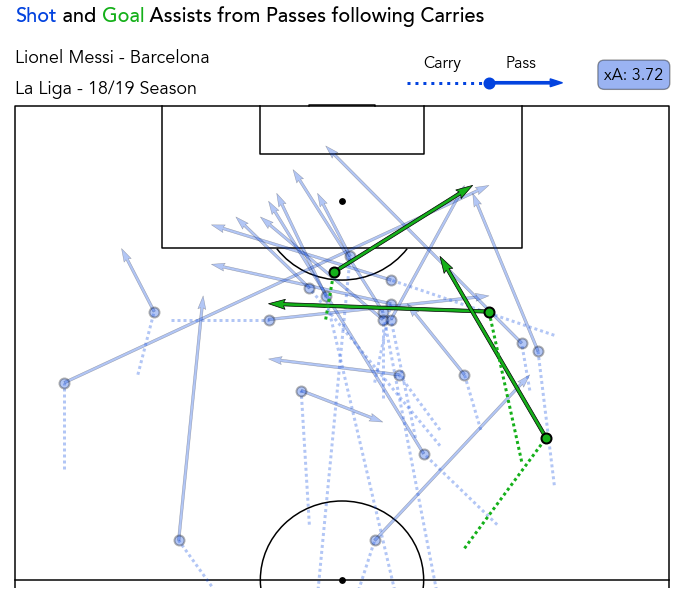

In [94]:
from highlight_text.htext import htext, fig_htext
from matplotlib.lines import Line2D 

fig, ax = dp.draw_pitch('w','k','v','h')

i = 0
year = str(years[i])
season = str(seasons[i])
car_s = car_p_ft[year][car_p_ft[year]['pass_outcome'] == 'Successful']
car_u = car_p_ft[year][car_p_ft[year]['pass_outcome'] == 'Unsuccessful']
car_sa = car_p_ft[year][(car_p_ft[year]['pass_outcome'] == 'Shot Assist')]
car_ga = car_p_ft[year][(car_p_ft[year]['pass_outcome'] == 'Goal Assist')]
pass_s = pass_c_ft[year][(pass_c_ft[year]['outcome'] == 'Complete')&
                           (pass_c_ft[year]['shot_assist'].isnull())&
                          (pass_c_ft[year]['goal_assist'].isnull())]
pass_u = pass_c_ft[year][pass_c_ft[year]['outcome'] == 'Incomplete']
pass_sa = pass_c_ft[year][pass_c_ft[year]['shot_assist'].notnull()]
pass_ga = pass_c_ft[year][pass_c_ft[year]['goal_assist'].notnull()]

xA_tot = pass_c_ft[year]['xA'].sum()

xcs = car_s['x'].values
ycs = car_s['y'].values
xcse = car_s['end_x'].values
ycse = car_s['end_y'].values

xcsa = car_sa['x'].values
ycsa = car_sa['y'].values
xcsae = car_sa['end_x'].values
ycsae = car_sa['end_y'].values

xcga = car_ga['x'].values
ycga = car_ga['y'].values
xcgae = car_ga['end_x'].values
ycgae = car_ga['end_y'].values

xps = pass_s['x'].values
yps = pass_s['y'].values
xpse = pass_s['end_x'].values
ypse = pass_s['end_y'].values

xpsa = pass_sa['x'].values
ypsa = pass_sa['y'].values
xpsae = pass_sa['end_x'].values
ypsae = pass_sa['end_y'].values

xpga = pass_ga['x'].values
ypga = pass_ga['y'].values
xpgae = pass_ga['end_x'].values
ypgae = pass_ga['end_y'].values

zo=100
ax.plot([ycsa,ycsae],[xcsa,xcsae],':o',c='xkcd:blue',mec='k',markevery=[1],dashes=(1,1),alpha=0.3,zorder=zo+2)
ax.quiver(ypsa,xpsa,ypsae-ypsa,xpsae-xpsa,angles='xy',scale_units='xy',scale=1,facecolor='xkcd:blue',edgecolor='k',width=0.004,
         linewidth=0.5,alpha=0.3,zorder=zo+2)
ax.plot([ycga,ycgae],[xcga,xcgae],':o',c='xkcd:green',mec='k',markevery=[1],dashes=(1,1),alpha=1,zorder=zo+3)
ax.quiver(ypga,xpga,ypgae-ypga,xpgae-xpga,angles='xy',scale_units='xy',scale=1,lw=1,
          facecolor='xkcd:green',edgecolor='k',width=0.005,linewidth=0.7,alpha=1,zorder=zo+3)

ax.text(0.0,125,nicknames[messi] + ' - Barcelona',ha='left',va='bottom',fontsize=18,zorder=zo)
ax.text(0.0,121,'La Liga - {} Season'.format(season),ha='left',va='bottom',fontsize=18,zorder=zo,)

htext(s = '<Shot> and <Goal> Assists from Passes following Carries',x = 0.0, y = 130,color = 'k', 
      highlight_colors = ['xkcd:blue','xkcd:green'],fontsize=20,string_weight = 'semibold',
      highlight_weights=['semibold'])

ax.add_line(Line2D([48,58],[123,123],c='xkcd:blue',ls=':',lw=3,marker='o',markevery=[1],clip_on=False,visible=True))
ax.arrow(58,123,9,0,color='xkcd:blue',width=0.3,head_width=1,length_includes_head=True,clip_on=False)

ax.text(50,124.5,'Carry',fontsize=16,ha='left',va='bottom')
ax.text(60,124.5,'Pass',fontsize=16,ha='left',va='bottom')

ax.text(0.98,1.04,'xA: {:.2f}'.format(xA_tot),transform=ax.transAxes,fontsize=16,
        bbox=dict(boxstyle='round,pad=0.4',facecolor='xkcd:blue',edgecolor='k',alpha=0.4),ha='right',zorder=zo)

plt.show()
#fig.savefig('example_plots/carry_map.pdf',bbox_inches='tight')